Skipping invalid job line: 
Skipping invalid job line: 


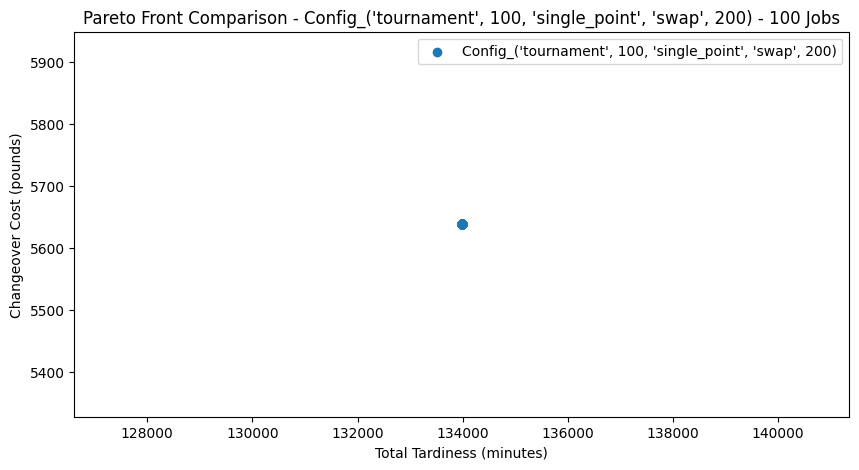

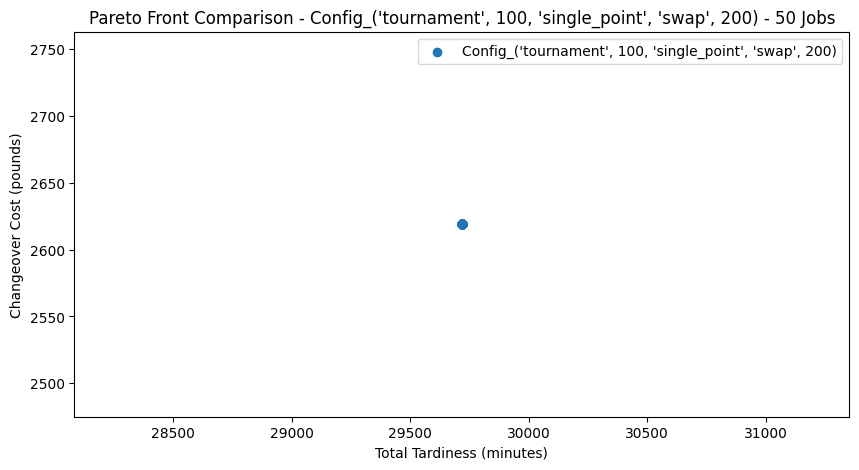

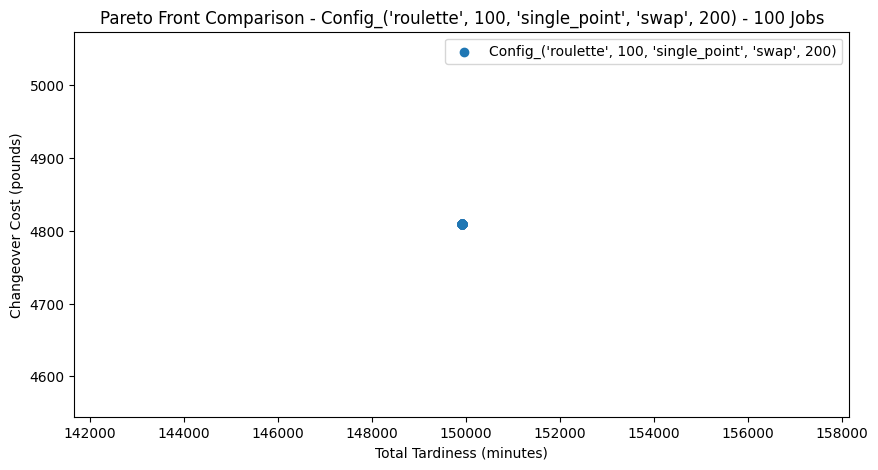

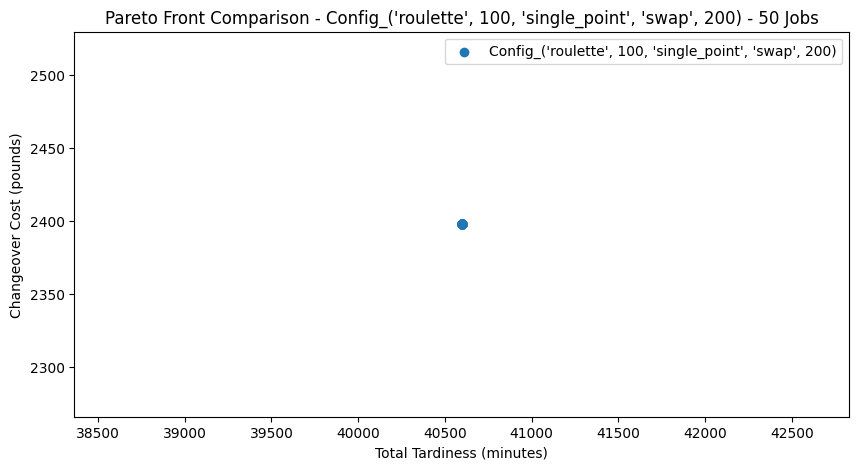

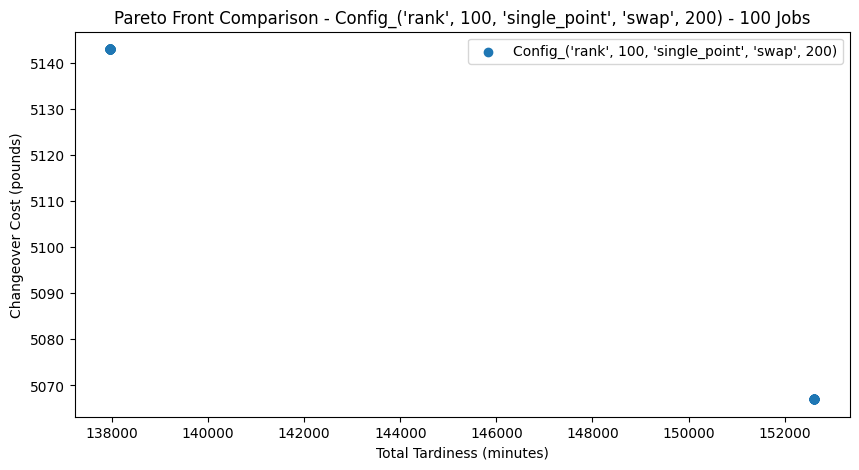

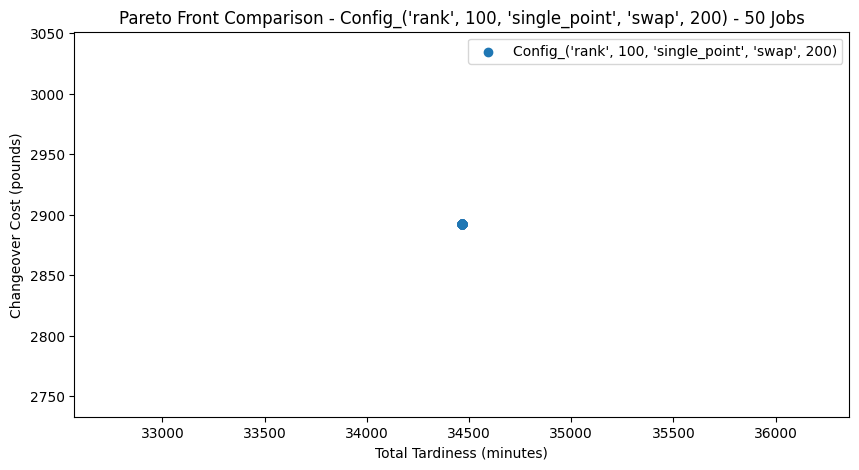

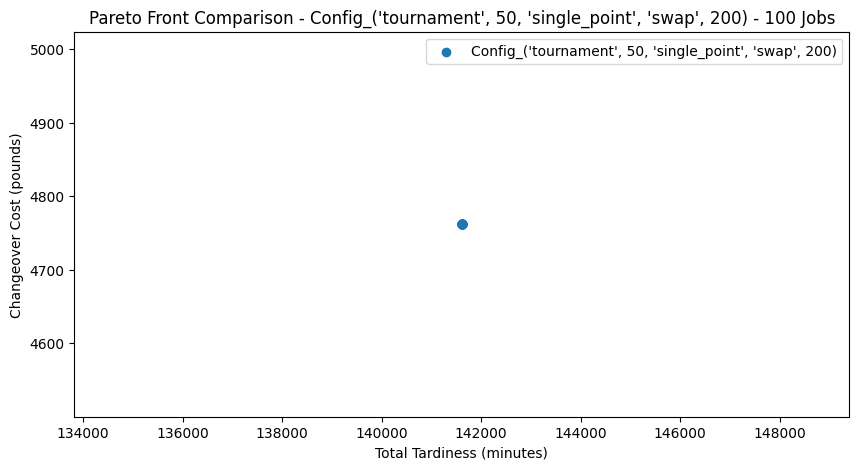

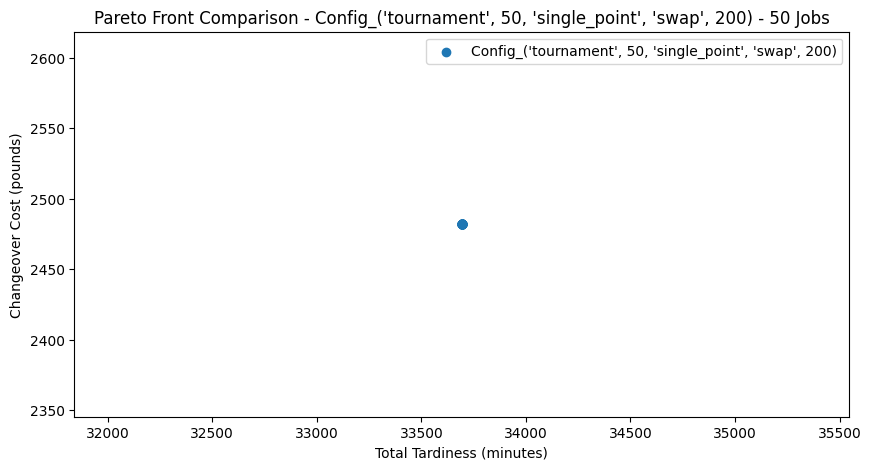

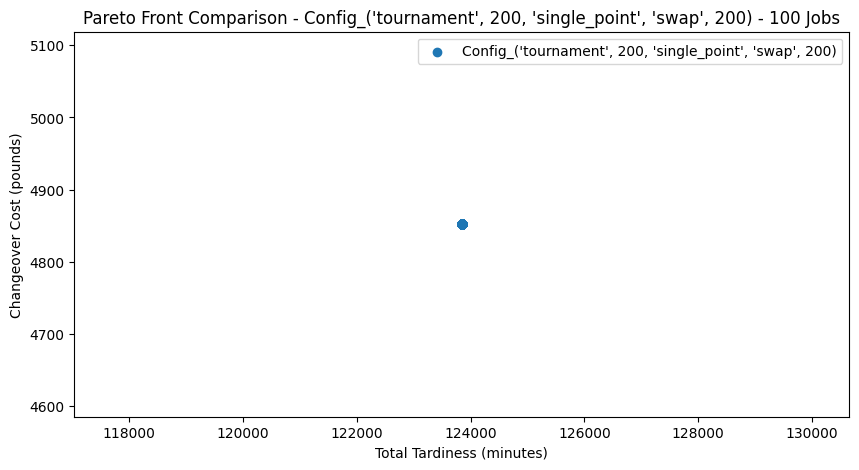

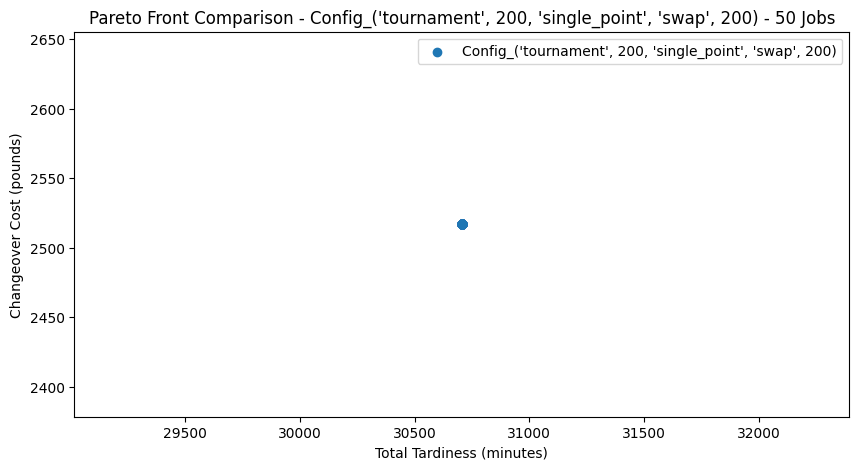

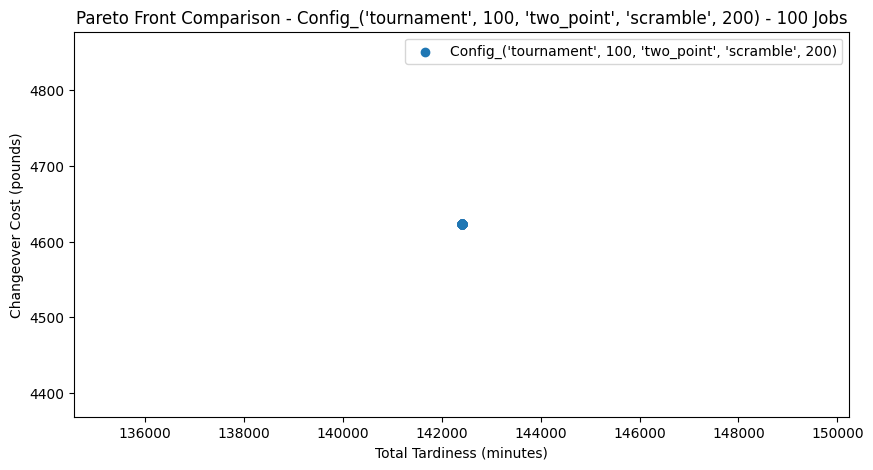

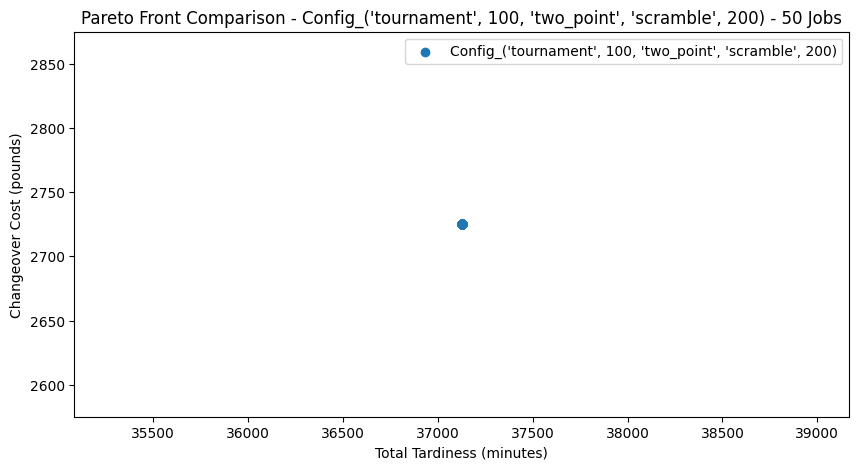

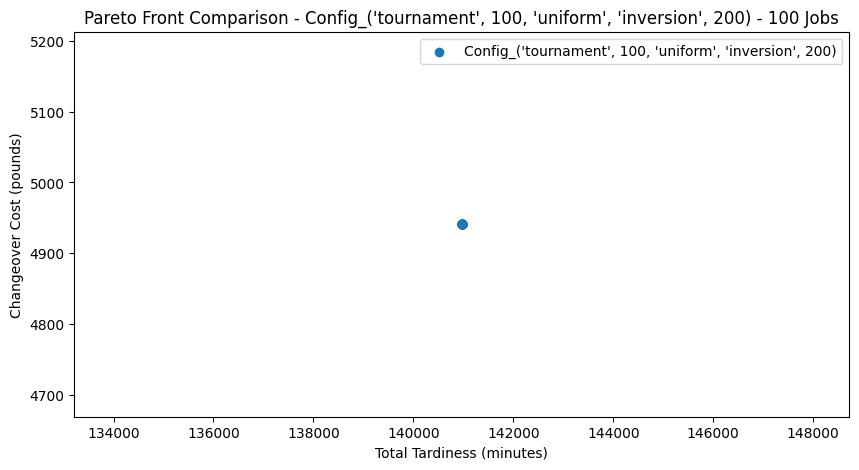

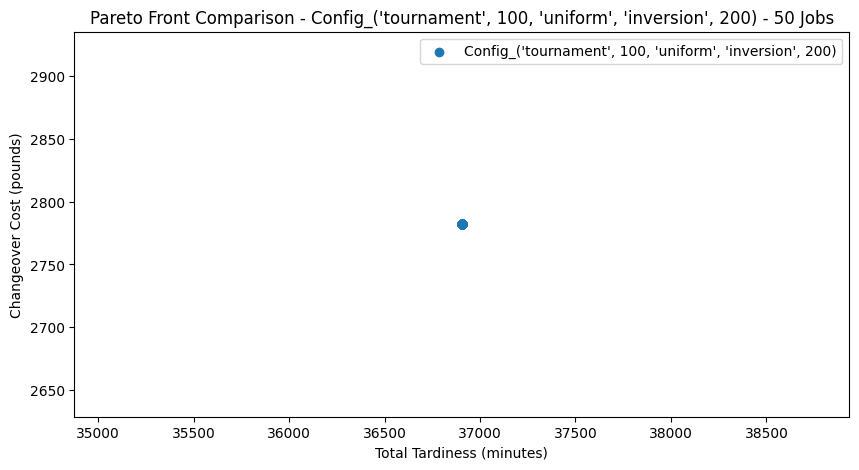

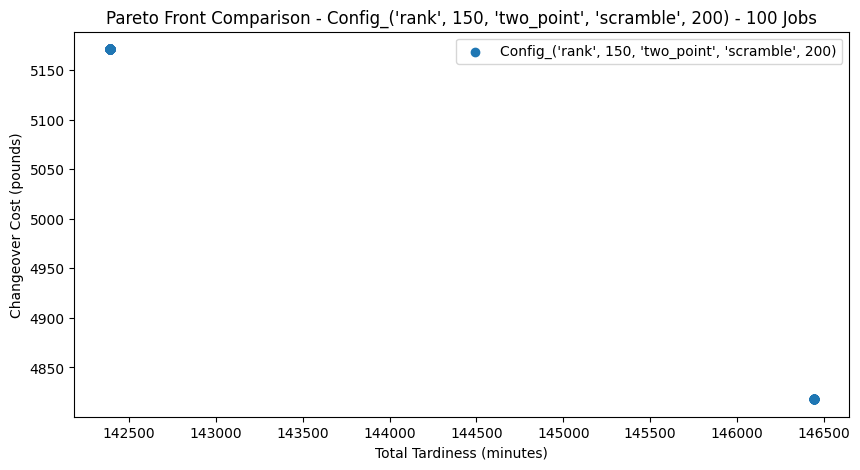

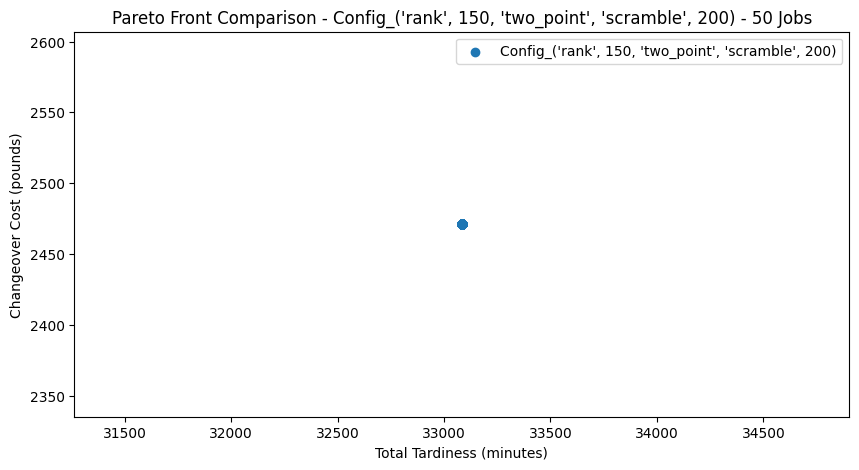

  Selection Operator  Population Size Crossover Operator Mutation Operator  \
0         tournament              100       single_point              swap   
1           roulette              100       single_point              swap   
2               rank              100       single_point              swap   
3         tournament               50       single_point              swap   
4         tournament              200       single_point              swap   
5         tournament              100          two_point          scramble   
6         tournament              100            uniform         inversion   
7               rank              150          two_point          scramble   

   Generations  Avg Tardiness (100 Jobs)  Avg Changeover (100 Jobs)  \
0          200             140849.231947                5090.242888   
1          200             140800.720000                4897.436000   
2          200             139175.909091                5064.090909   
3          20

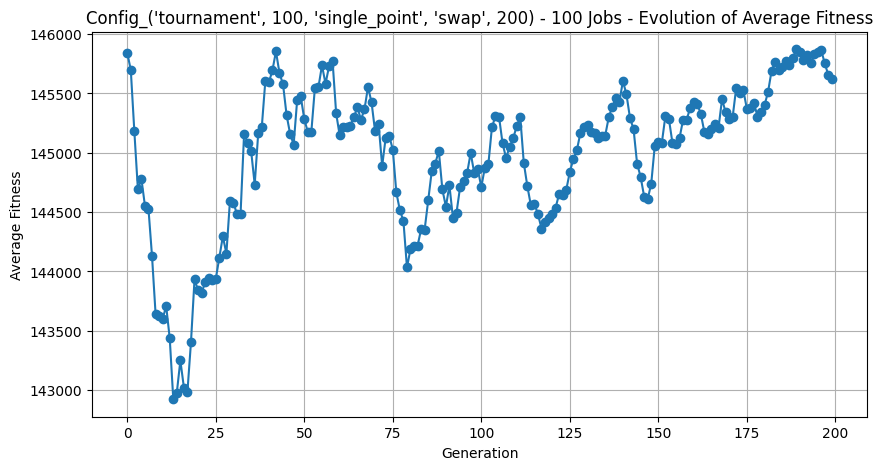

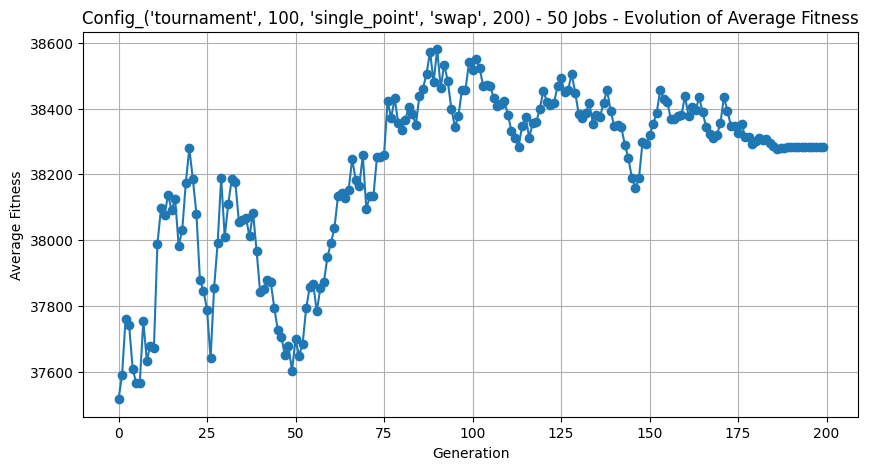

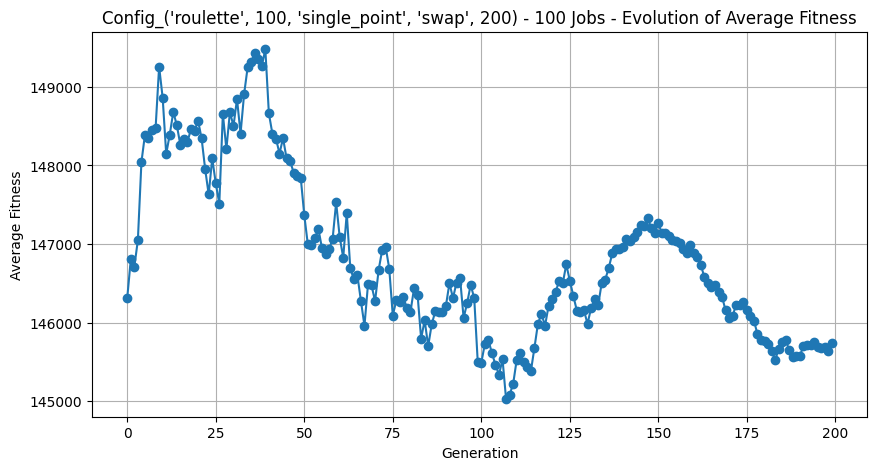

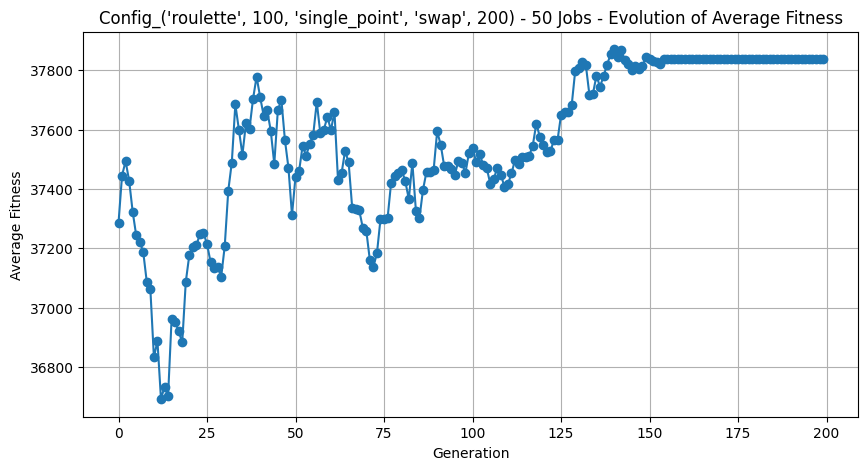

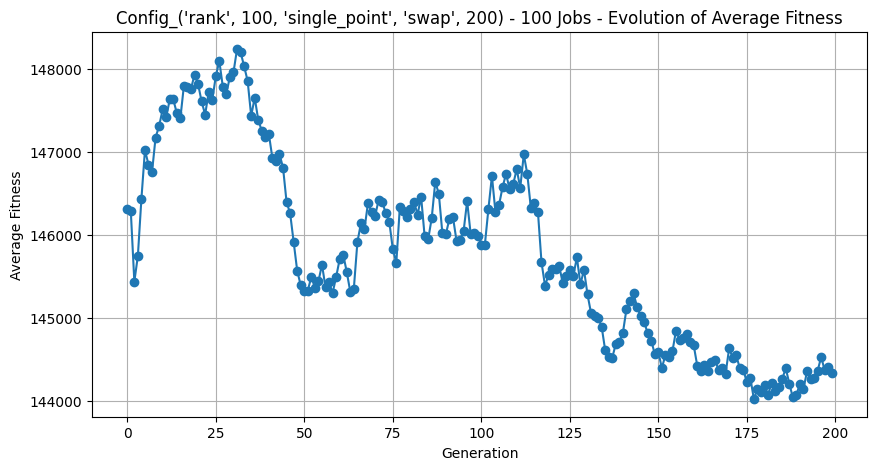

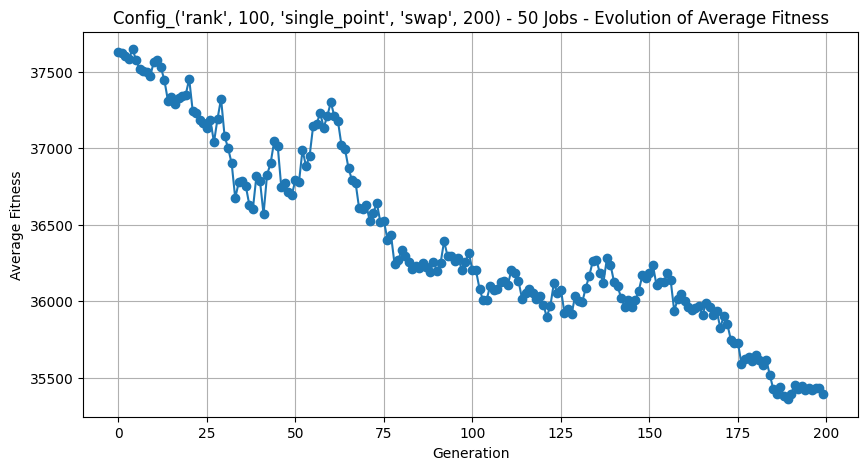

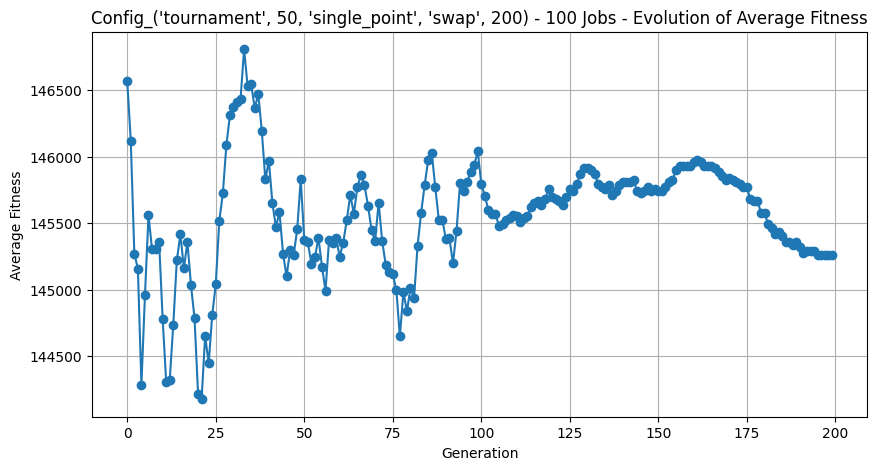

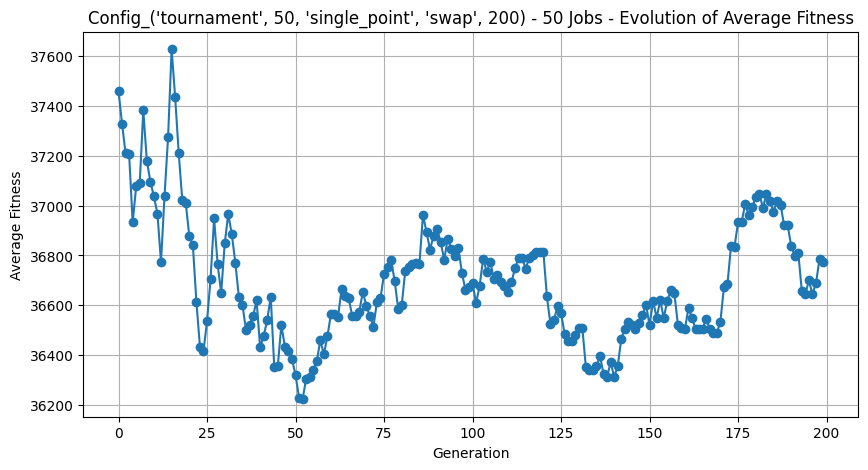

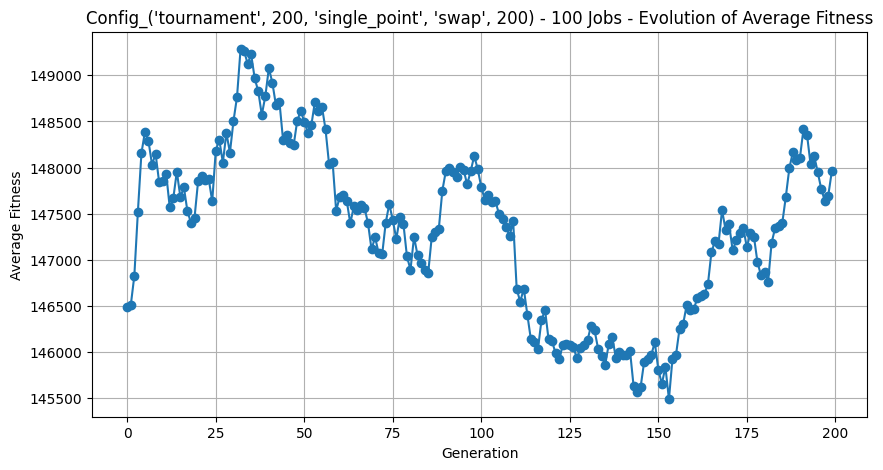

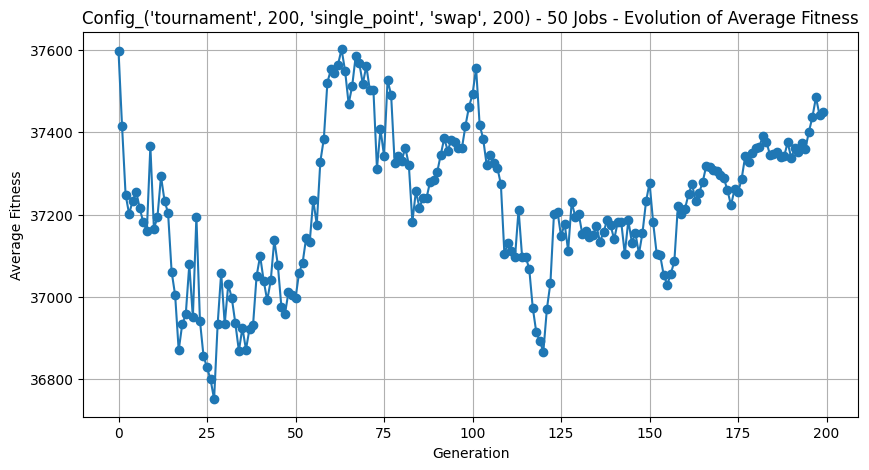

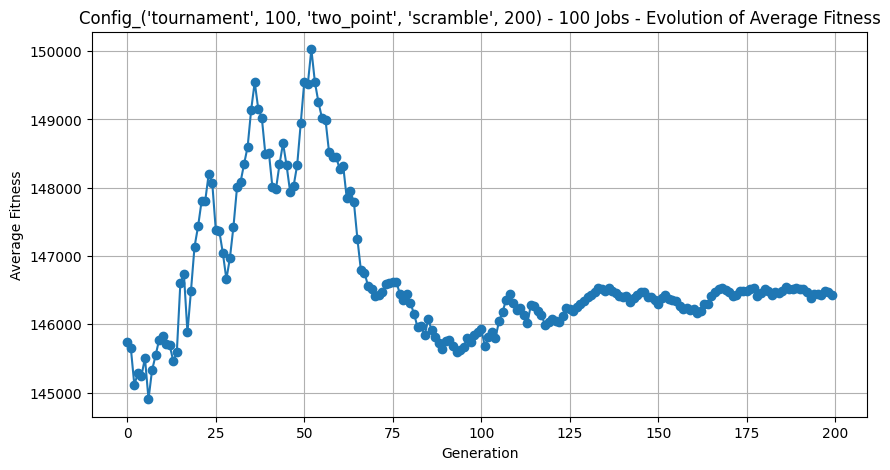

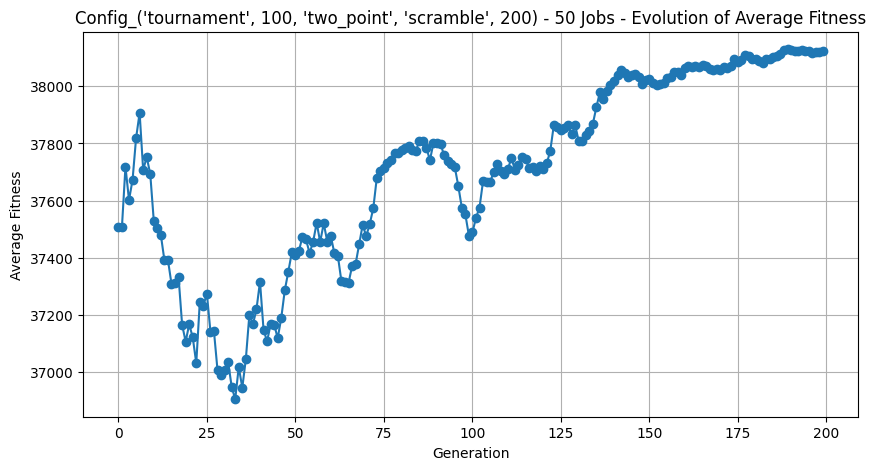

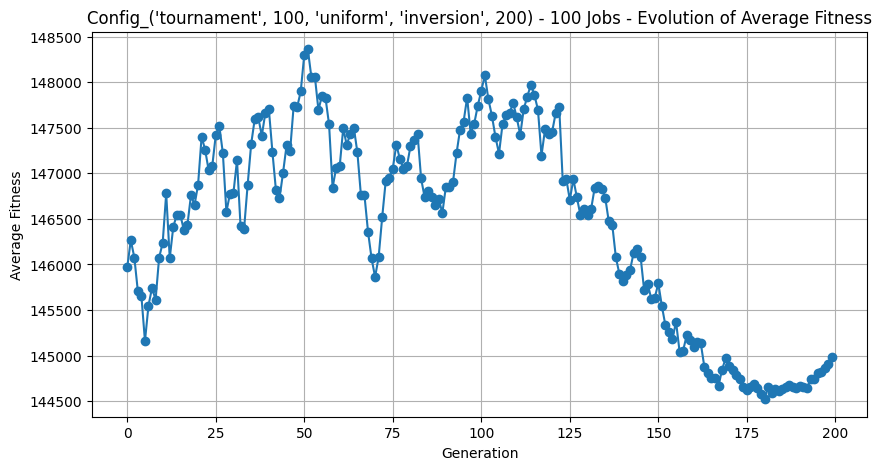

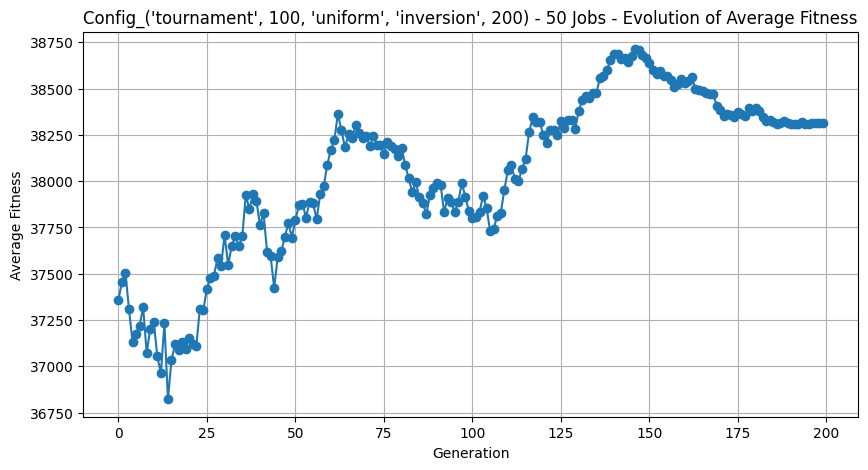

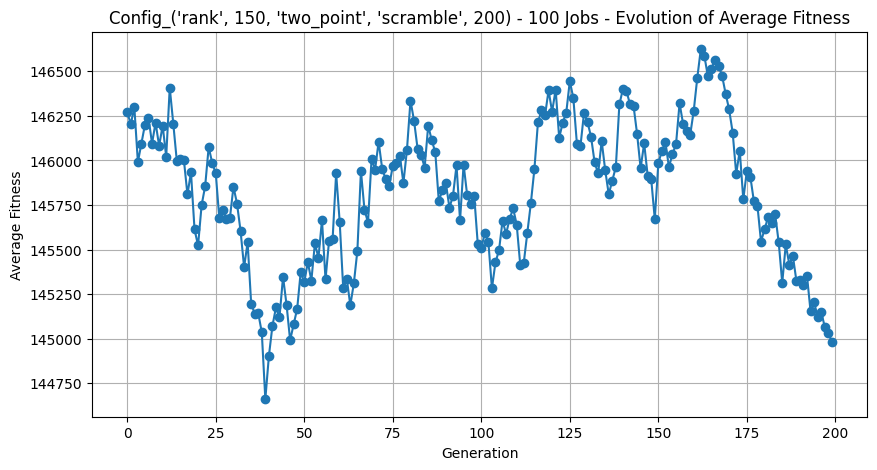

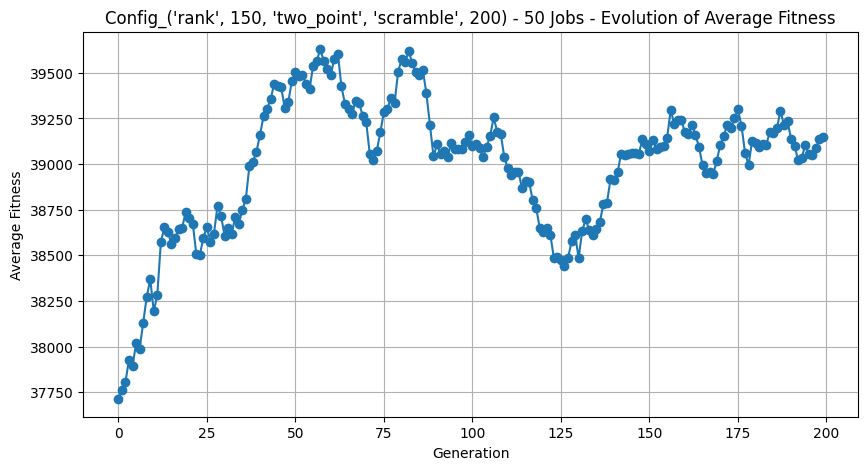

Best Combination for 100 Jobs:
Selection Operator                    rank
Population Size                        100
Crossover Operator            single_point
Mutation Operator                     swap
Generations                            200
Avg Tardiness (100 Jobs)     139175.909091
Avg Changeover (100 Jobs)      5064.090909
Avg Time (100 Jobs)               2.215573
Avg Tardiness (50 Jobs)           32795.57
Avg Changeover (50 Jobs)          2604.144
Avg Time (50 Jobs)                2.005035
Name: 2, dtype: object
Best Combination for 50 Jobs:
Selection Operator                    rank
Population Size                        100
Crossover Operator            single_point
Mutation Operator                     swap
Generations                            200
Avg Tardiness (100 Jobs)     139175.909091
Avg Changeover (100 Jobs)      5064.090909
Avg Time (100 Jobs)               2.215573
Avg Tardiness (50 Jobs)           32795.57
Avg Changeover (50 Jobs)          2604.144
Avg Time (50 

In [1]:

import time
import pandas as pd
from nsga_ii import nsga_ii, tournament_selection, roulette_wheel_selection, rank_based_selection, single_point_crossover, two_point_crossover, uniform_crossover, swap_mutation, scramble_mutation, inversion_mutation
from utils import read_and_parse_dataset
from plotting import plot_pareto_fronts, plot_fitness_evolution
from config import key_configurations, get_operator_function, crossover_rate, mutation_rate, num_trials


# Define the key configurations
key_configurations = [
    ('tournament', 100, 'single_point', 'swap', 200),  # Baseline Configuration
    ('roulette', 100, 'single_point', 'swap', 200),   # Different Selection Operators
    ('rank', 100, 'single_point', 'swap', 200),       # Different Selection Operators
    ('tournament', 50, 'single_point', 'swap', 200),  # Different Population Sizes
    ('tournament', 200, 'single_point', 'swap', 200), # Different Population Sizes
    ('tournament', 100, 'two_point', 'scramble', 200),# Different Reproduction Operators
    ('tournament', 100, 'uniform', 'inversion', 200), # Different Reproduction Operators
    ('rank', 150, 'two_point', 'scramble', 200)       # Combination of Different Parameters
]

# Define a function to convert operator names to functions
def get_operator_function(operator_name):
    operators = {
        'tournament': tournament_selection,
        'roulette': roulette_wheel_selection,
        'rank': rank_based_selection,
        'single_point': single_point_crossover,
        'two_point': two_point_crossover,
        'uniform': uniform_crossover,
        'swap': swap_mutation,
        'scramble': scramble_mutation,
        'inversion': inversion_mutation
    }
    return operators[operator_name]

# Fixing the calculate_crowding_distance function
def calculate_crowding_distance(fitnesses, front):
    distance = [0] * len(fitnesses)
    for i in range(len(fitnesses[0])):
        sorted_fitnesses = sorted(enumerate(fitnesses), key=lambda x: x[1][i])
        distance[sorted_fitnesses[0][0]] = float('inf')
        distance[sorted_fitnesses[-1][0]] = float('inf')
        
        max_value = max(fitnesses, key=lambda x: x[i])[i]
        min_value = min(fitnesses, key=lambda x: x[i])[i]
        if max_value == min_value:
            continue  # Avoid division by zero

        range_value = max_value - min_value
        if range_value == 0:
            range_value = 1  # To avoid division by zero

        for j in range(1, len(sorted_fitnesses) - 1):
            distance[sorted_fitnesses[j][0]] += (sorted_fitnesses[j+1][1][i] - sorted_fitnesses[j-1][1][i]) / range_value
    return distance

# Function to run experiments
def run_experiment(jobs, changeover_costs, config):
    pareto_fronts = []
    running_times = []
    fitness_evolution = []
    for _ in range(config['num_trials']):
        pareto_front, running_time, fitness_hist = nsga_ii(
            jobs, changeover_costs,
            population_size=config['population_size'],
            generations=config['generations'],
            crossover_rate=config['crossover_rate'],
            mutation_rate=config['mutation_rate'],
            selection_operator=config['selection_operator'],
            crossover_operator=config['crossover_operator'],
            mutation_operator=config['mutation_operator']
        )
        running_times.append(running_time)
        pareto_fronts.append(pareto_front)
        fitness_evolution.append(fitness_hist)
    
    avg_fitness_evolution = [sum(gen) / len(gen) for gen in zip(*fitness_evolution)]
    return pareto_fronts, running_times, avg_fitness_evolution

# Function to summarize results
def summarize_results(results):
    summary = []
    for key, result in results.items():
        summary.append({
            'Selection Operator': result['parameters'][0],
            'Population Size': result['parameters'][1],
            'Crossover Operator': result['parameters'][2],
            'Mutation Operator': result['parameters'][3],
            'Generations': result['parameters'][4],
            'Avg Tardiness (100 Jobs)': result['avg_tardiness_100'],
            'Avg Changeover (100 Jobs)': result['avg_changeover_100'],
            'Avg Time (100 Jobs)': result['avg_time_100'],
            'Avg Tardiness (50 Jobs)': result['avg_tardiness_50'],
            'Avg Changeover (50 Jobs)': result['avg_changeover_50'],
            'Avg Time (50 Jobs)': result['avg_time_50'],
        })
    
    summary_df = pd.DataFrame(summary)
    print(summary_df)
    return summary_df

if __name__ == "__main__":
    jobs_100, changeover_100 = read_and_parse_dataset('datasets/SMTTCC1problem')
    jobs_50, changeover_50 = read_and_parse_dataset('datasets/SMTTCC2problem')

    experiment_results = {}

    for params in key_configurations:
        config = {
            'selection_operator': get_operator_function(params[0]),
            'population_size': params[1],
            'crossover_operator': get_operator_function(params[2]),
            'mutation_operator': get_operator_function(params[3]),
            'generations': params[4],
            'crossover_rate': 0.8,  # Fixed crossover rate
            'mutation_rate': 0.1,   # Fixed mutation rate
            'num_trials': 5         # Number of trials to average results
        }
        
        pareto_fronts_100, running_times_100, fitness_evolution_100 = run_experiment(jobs_100, changeover_100, config)
        pareto_fronts_50, running_times_50, fitness_evolution_50 = run_experiment(jobs_50, changeover_50, config)
        
        # Unpack the pareto fronts and times
        fitness_values_100 = [ind for pf in pareto_fronts_100 for ind in pf]
        fitness_values_50 = [ind for pf in pareto_fronts_50 for ind in pf]

        avg_tardiness_100 = sum([ind[0] for ind in fitness_values_100]) / len(fitness_values_100)
        avg_changeover_100 = sum([ind[1] for ind in fitness_values_100]) / len(fitness_values_100)
        avg_time_100 = sum(running_times_100) / len(running_times_100)
        
        avg_tardiness_50 = sum([ind[0] for ind in fitness_values_50]) / len(fitness_values_50)
        avg_changeover_50 = sum([ind[1] for ind in fitness_values_50]) / len(fitness_values_50)
        avg_time_50 = sum(running_times_50) / len(running_times_50)
        
        experiment_results[f"Config_{params}"] = {
            'parameters': params,
            'avg_tardiness_100': avg_tardiness_100,
            'avg_changeover_100': avg_changeover_100,
            'avg_time_100': avg_time_100,
            'avg_tardiness_50': avg_tardiness_50,
            'avg_changeover_50': avg_changeover_50,
            'avg_time_50': avg_time_50,
            'pareto_fronts_100': pareto_fronts_100,
            'pareto_fronts_50': pareto_fronts_50,
            'fitness_evolution_100': fitness_evolution_100,
            'fitness_evolution_50': fitness_evolution_50
        }

    plot_pareto_fronts(experiment_results, 'Pareto Front Comparison')
    summary_df = summarize_results(experiment_results)

    # Plot fitness evolution for each configuration
    for config_name, result in experiment_results.items():
        plot_fitness_evolution(result['fitness_evolution_100'], f'{config_name} - 100 Jobs')
        plot_fitness_evolution(result['fitness_evolution_50'], f'{config_name} - 50 Jobs')

    # Identify the best combination
    best_combination_100 = summary_df.loc[summary_df['Avg Tardiness (100 Jobs)'].idxmin()]
    best_combination_50 = summary_df.loc[summary_df['Avg Tardiness (50 Jobs)'].idxmin()]

    print("Best Combination for 100 Jobs:")
    print(best_combination_100)

    print("Best Combination for 50 Jobs:")
    print(best_combination_50)


Skipping invalid job line: 
Skipping invalid job line: 


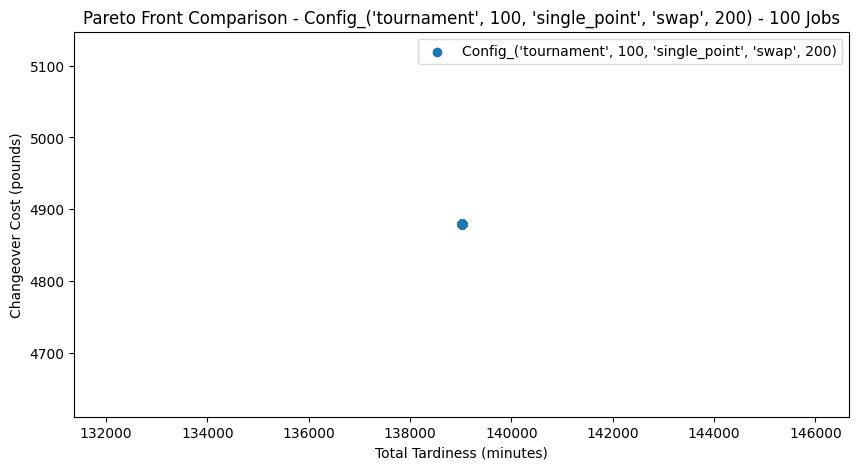

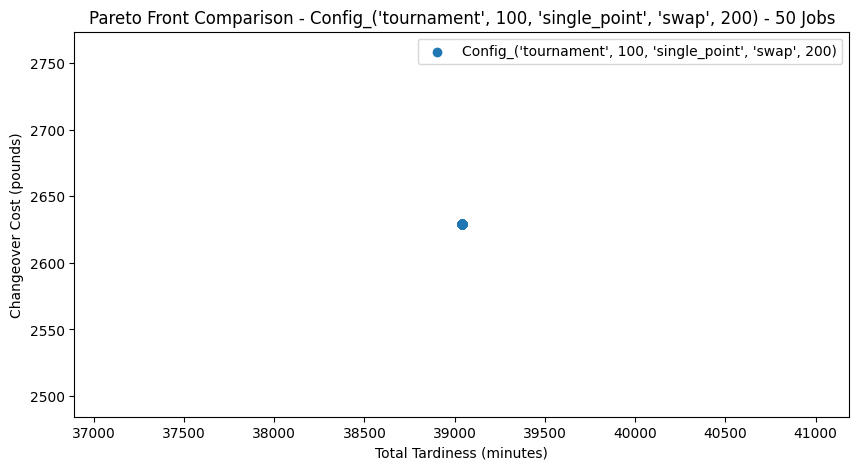

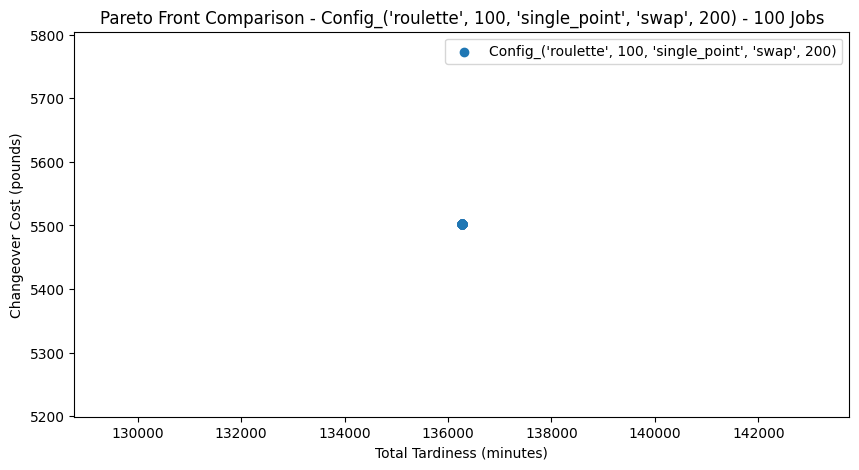

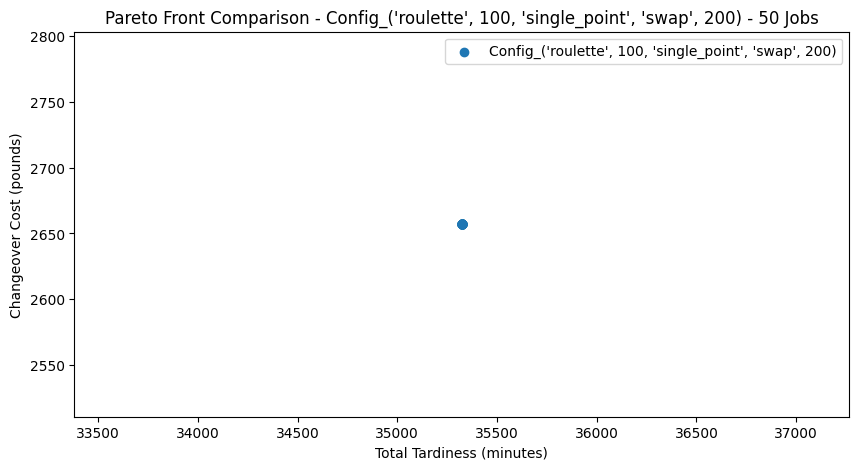

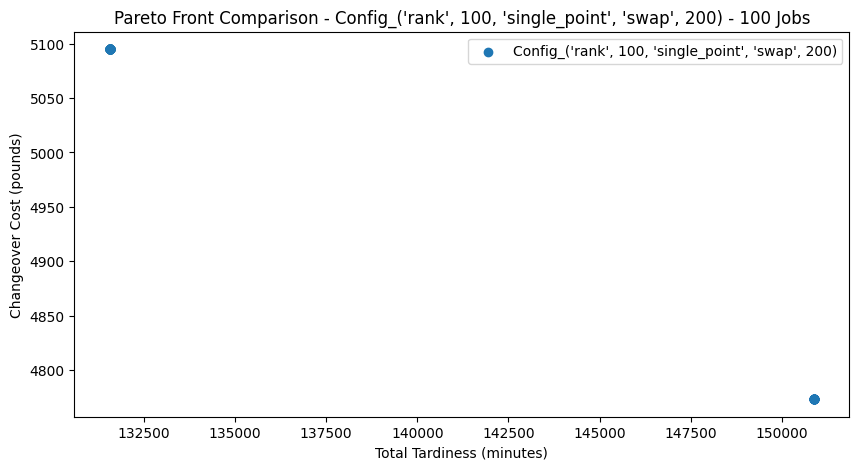

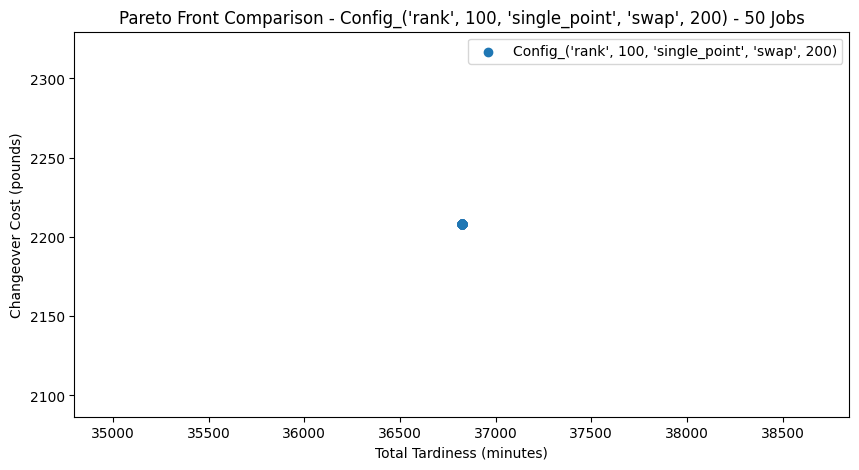

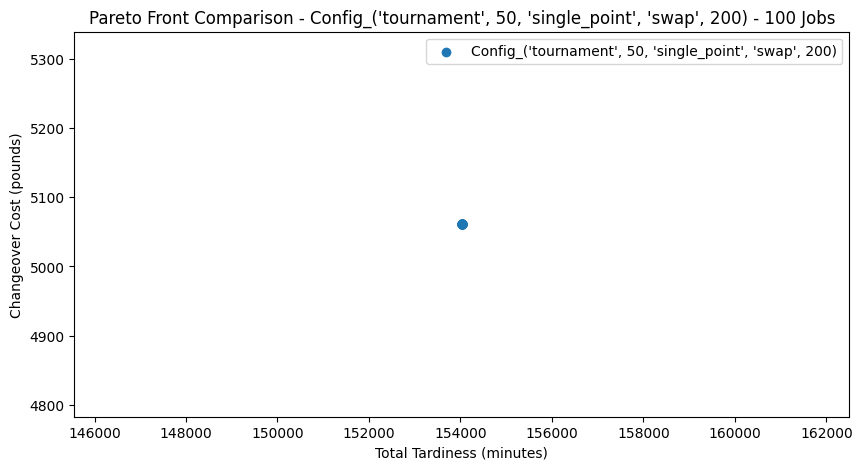

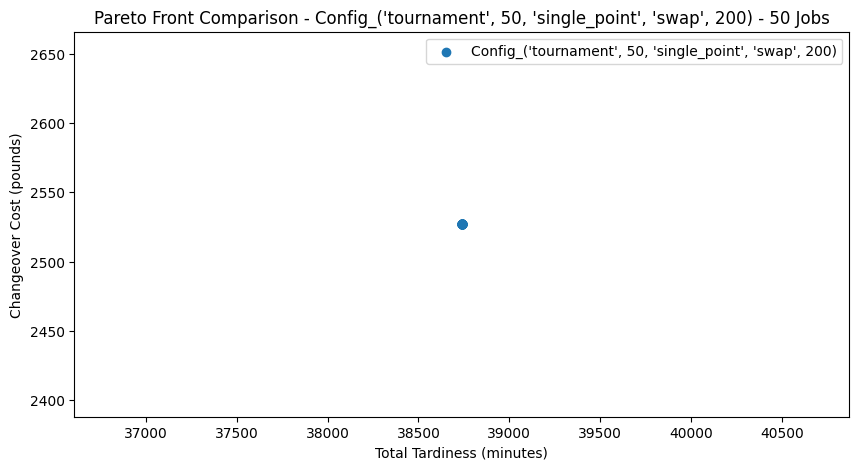

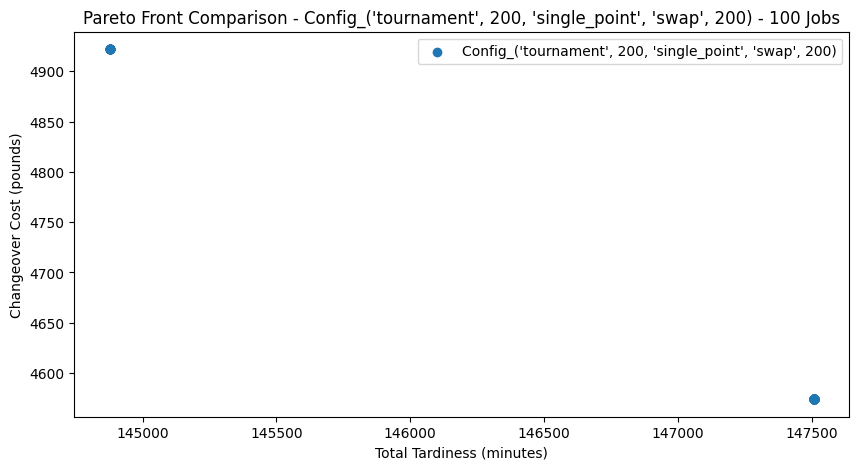

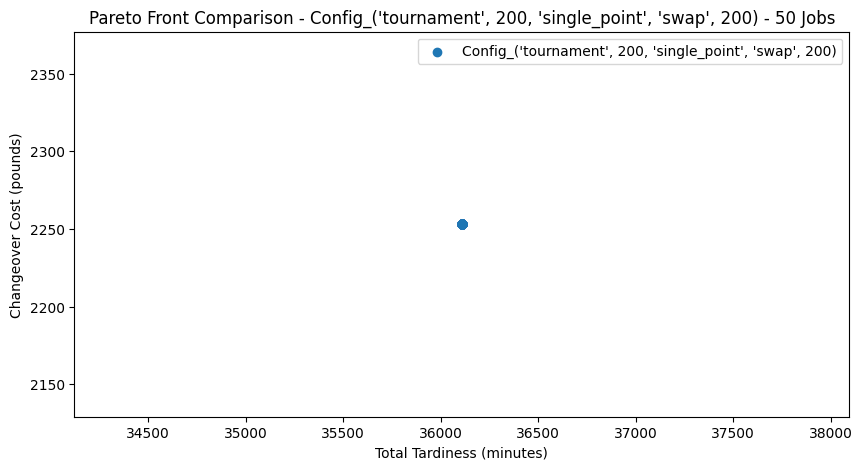

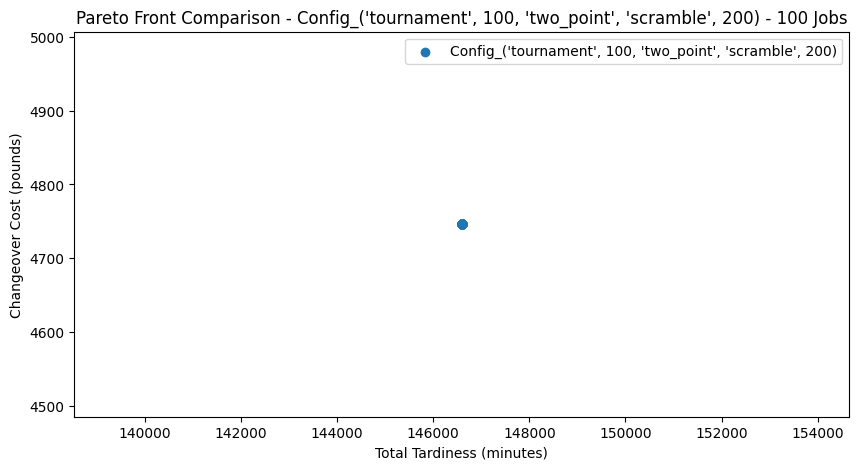

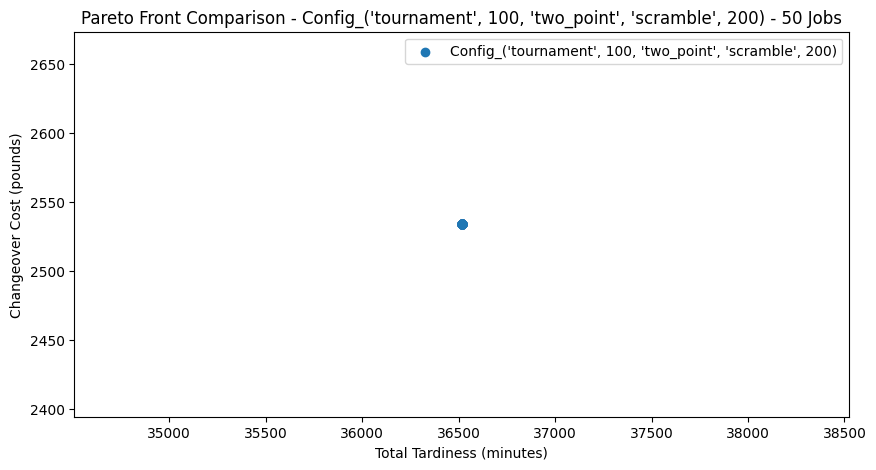

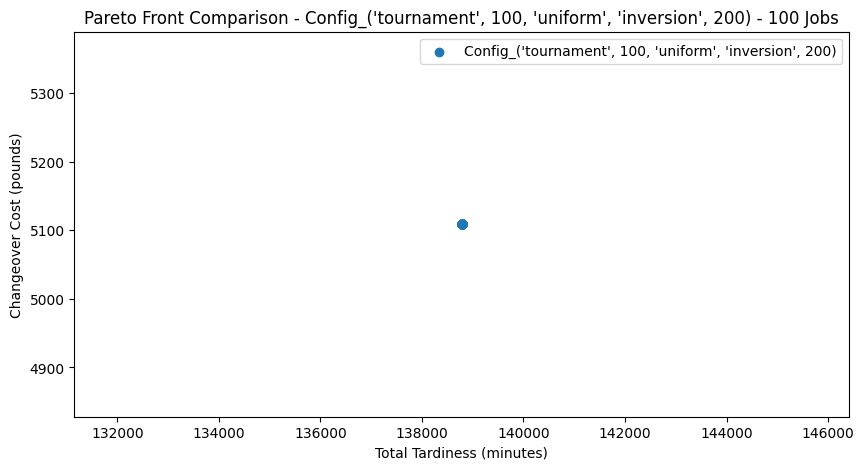

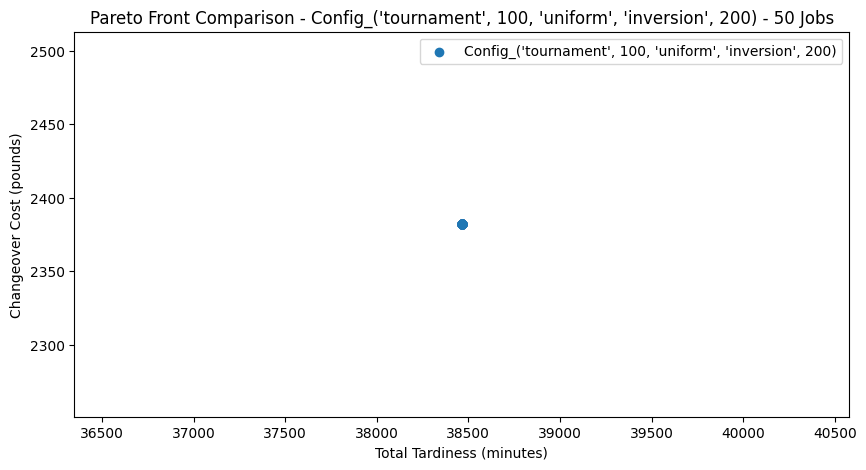

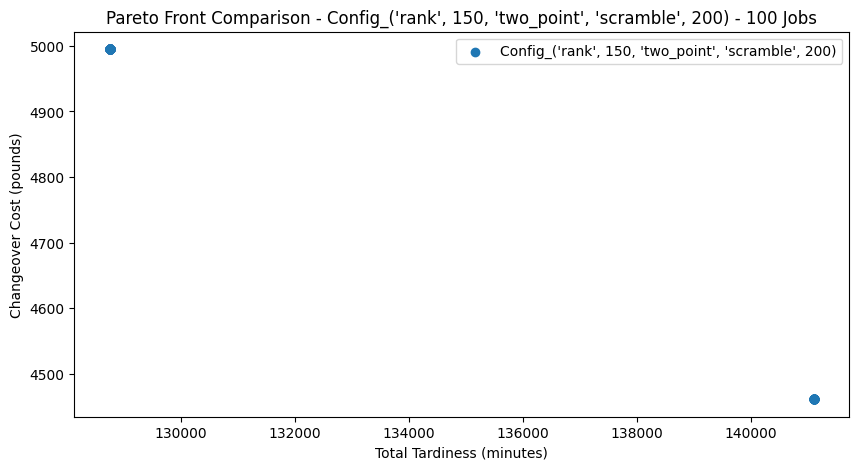

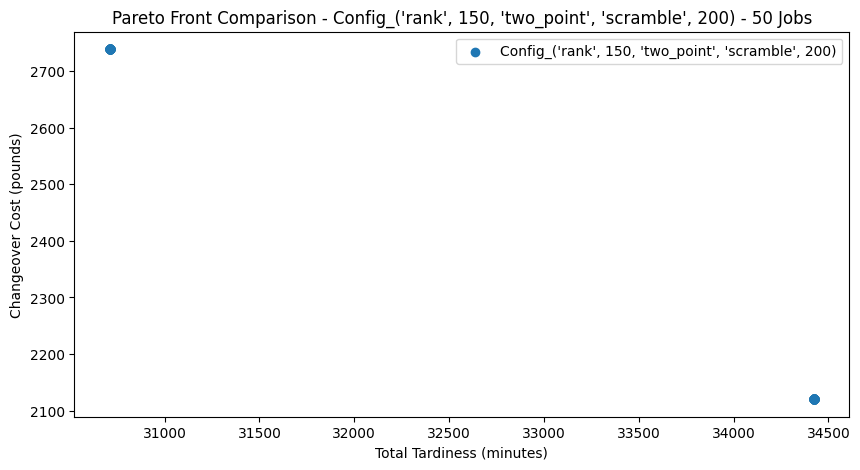

  Selection Operator  Population Size Crossover Operator Mutation Operator  \
0         tournament              100       single_point              swap   
1           roulette              100       single_point              swap   
2               rank              100       single_point              swap   
3         tournament               50       single_point              swap   
4         tournament              200       single_point              swap   
5         tournament              100          two_point          scramble   
6         tournament              100            uniform         inversion   
7               rank              150          two_point          scramble   

   Generations  Avg Tardiness (100 Jobs)  Avg Changeover (100 Jobs)  \
0          200             146566.800000                4974.692000   
1          200             133360.337349                4948.489157   
2          200             139718.802299                4836.393103   
3          20

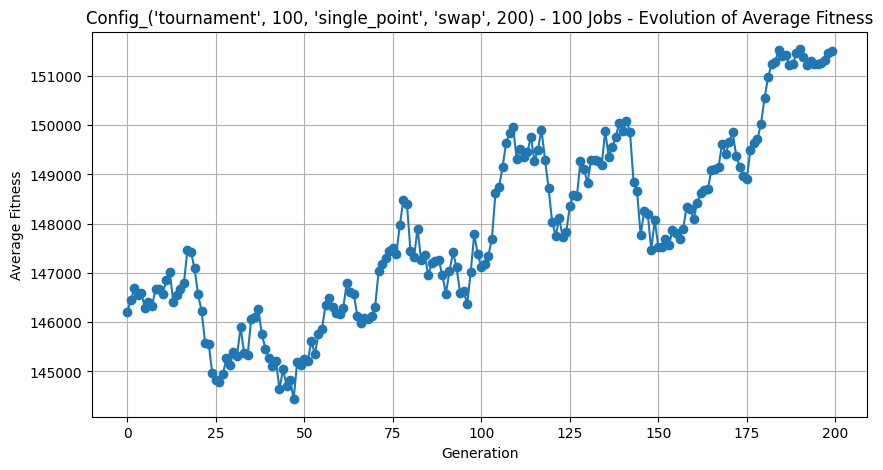

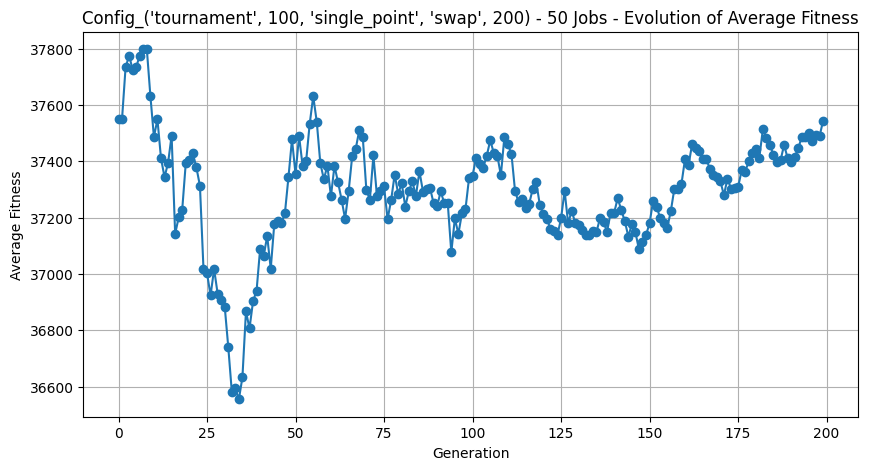

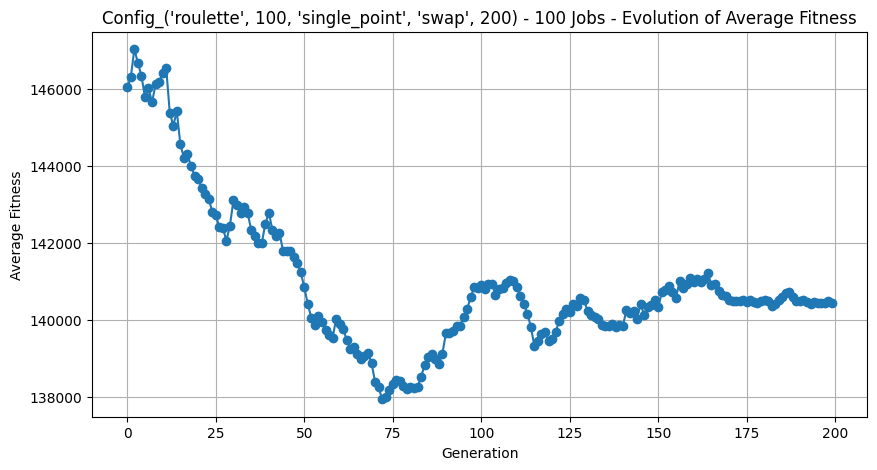

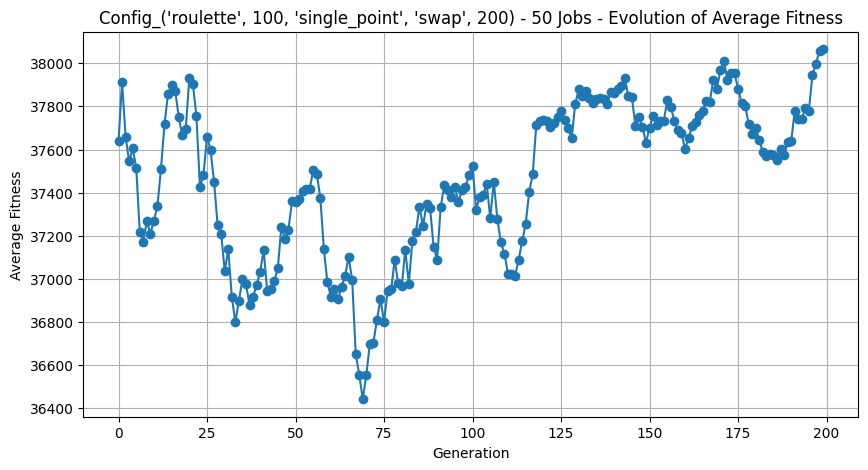

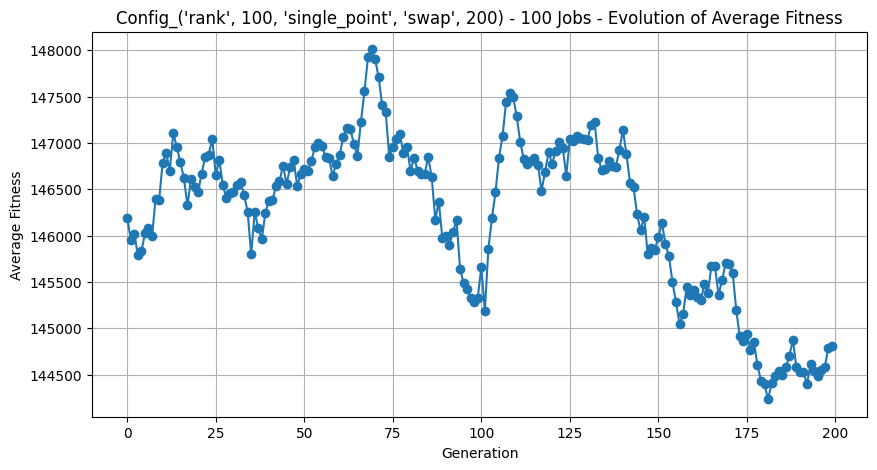

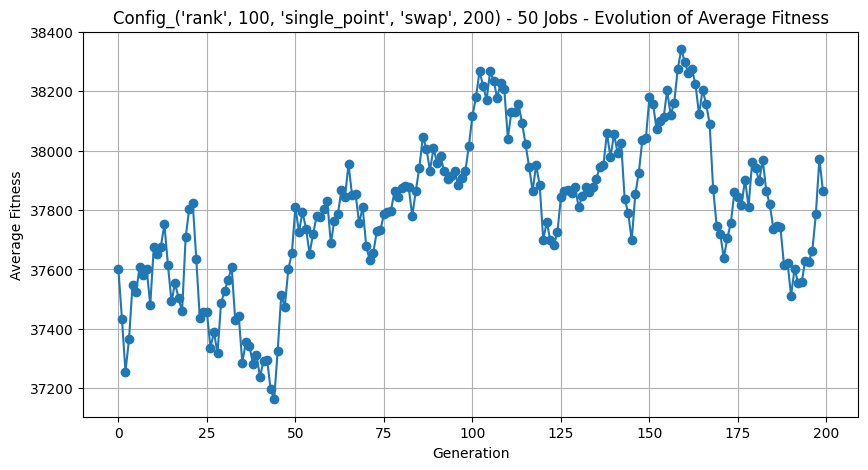

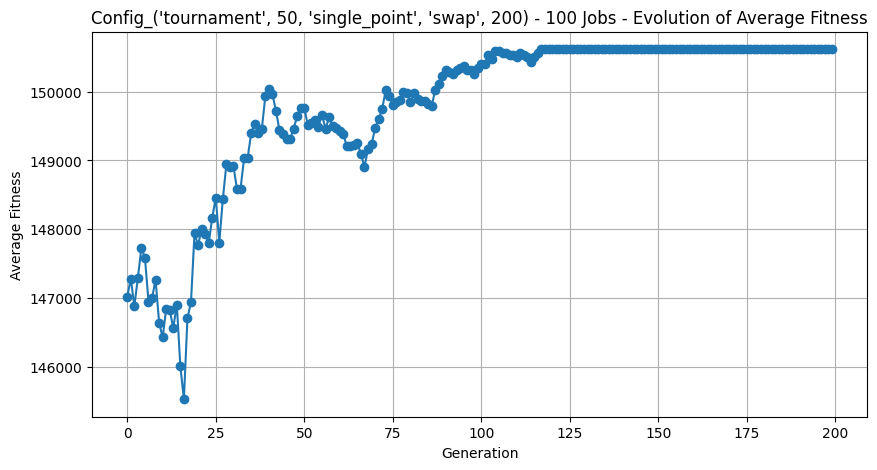

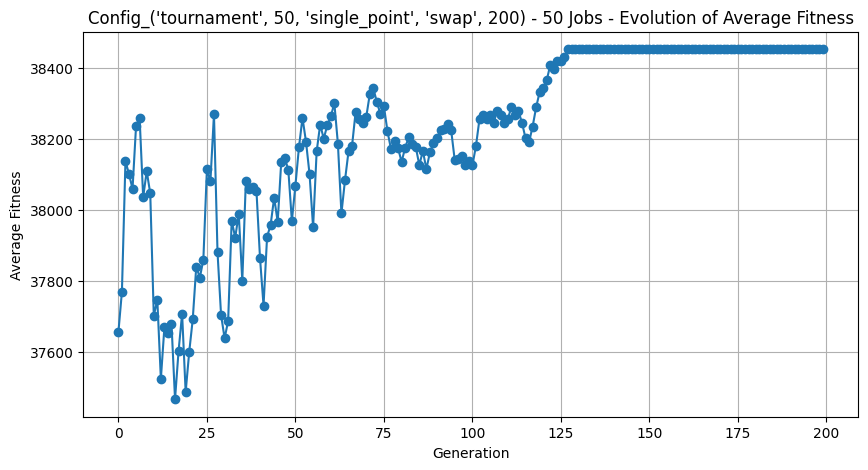

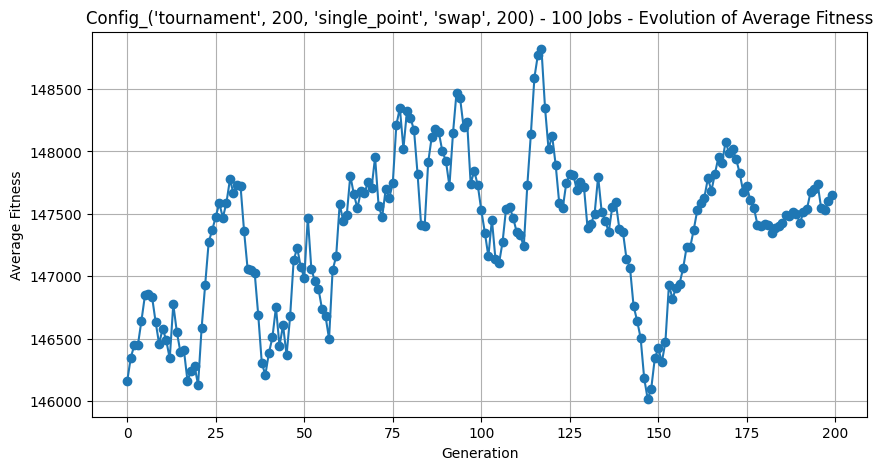

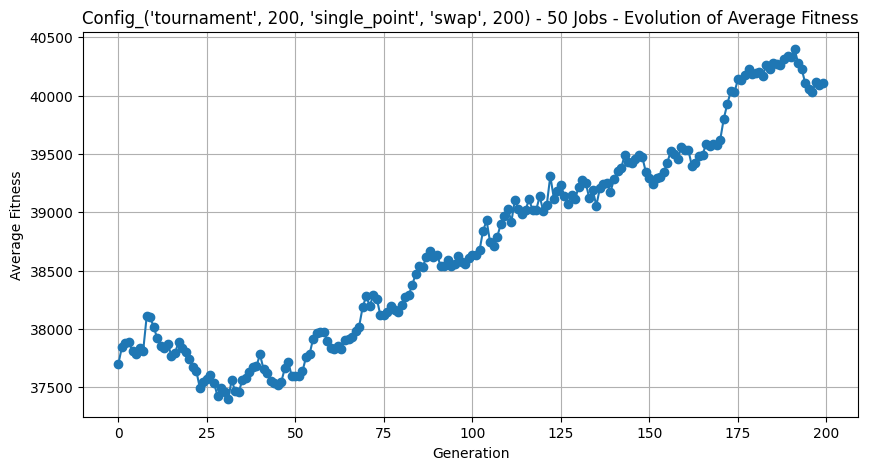

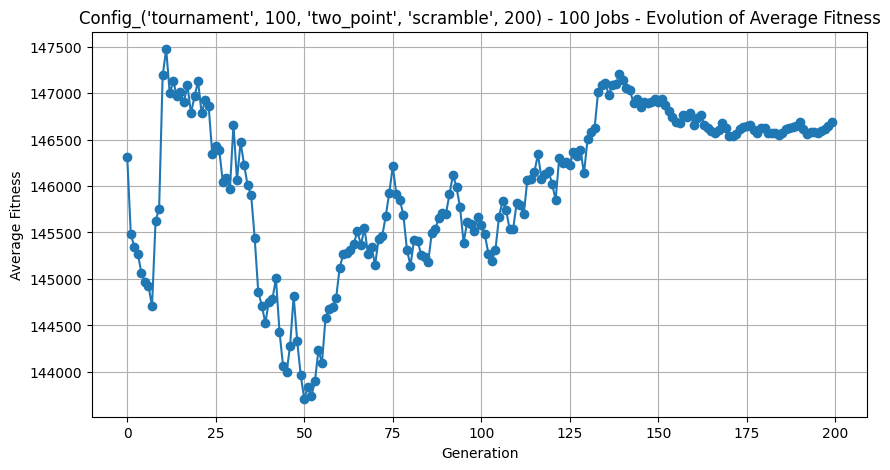

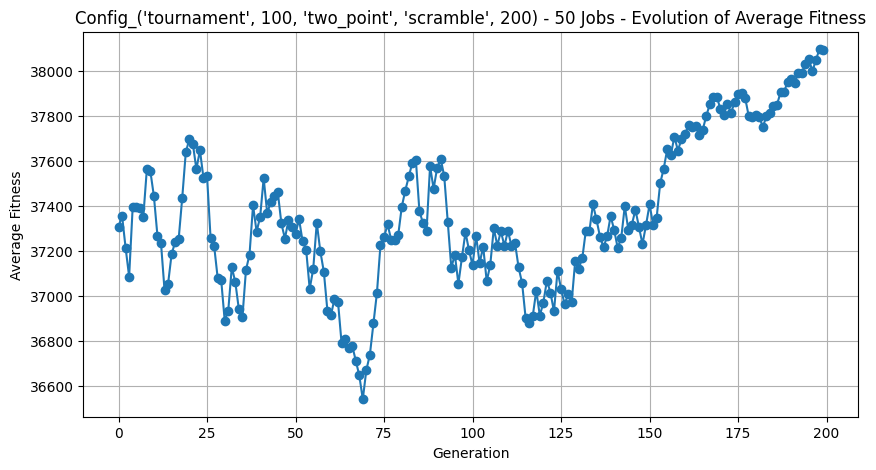

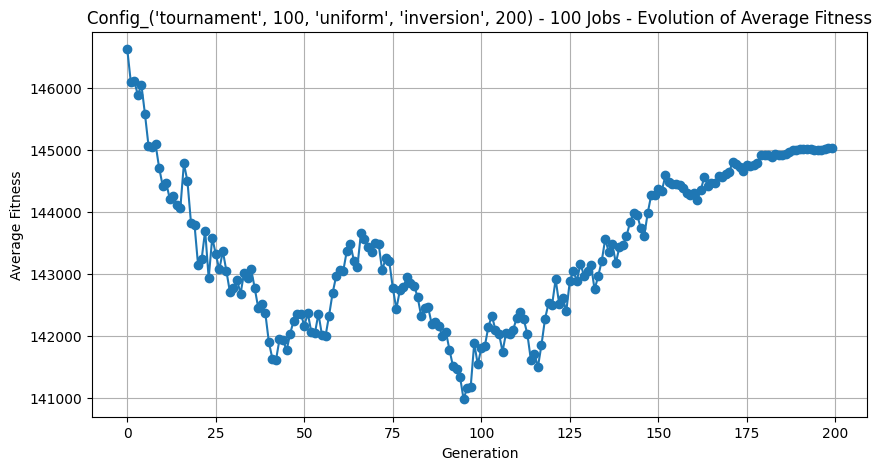

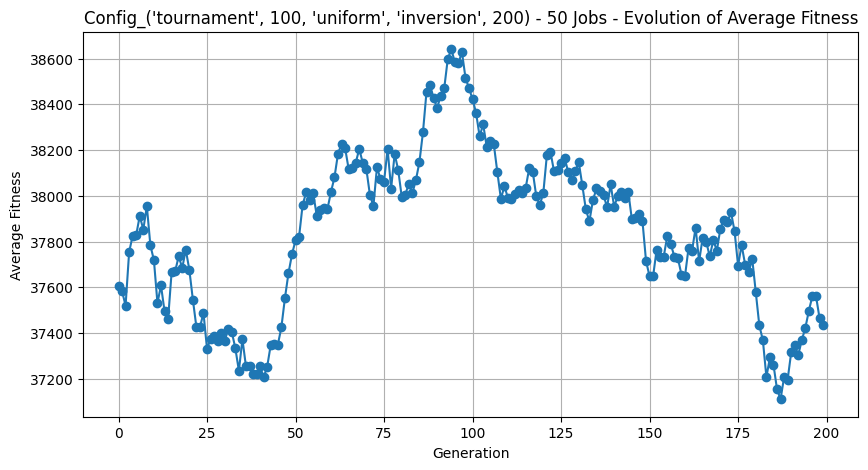

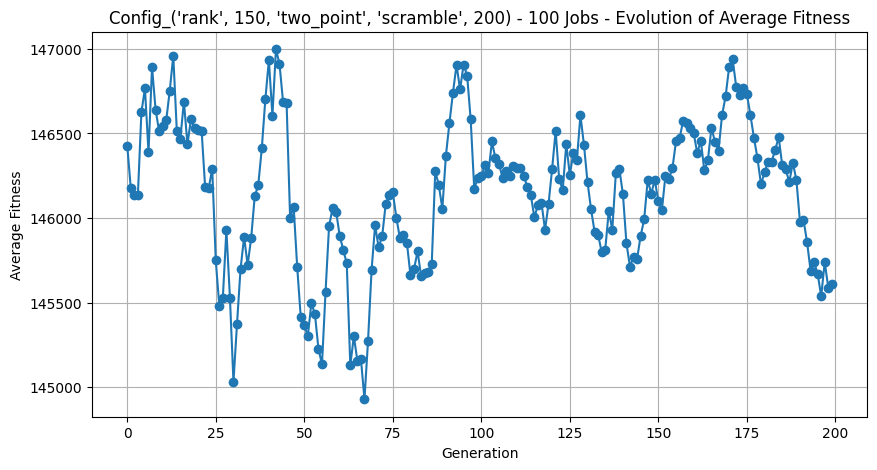

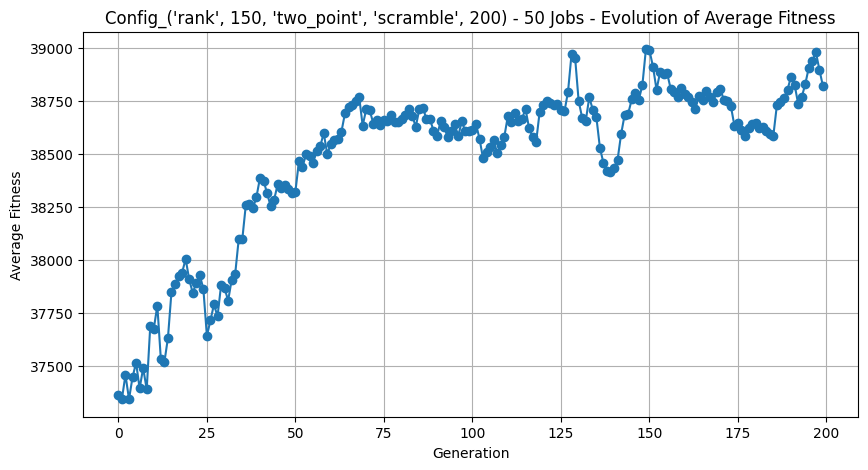

Best Combination for 100 Jobs:
Selection Operator                roulette
Population Size                        100
Crossover Operator            single_point
Mutation Operator                     swap
Generations                            200
Avg Tardiness (100 Jobs)     133360.337349
Avg Changeover (100 Jobs)      4948.489157
Avg Time (100 Jobs)               2.310851
Avg Tardiness (50 Jobs)       35180.473054
Avg Changeover (50 Jobs)        2638.01497
Avg Time (50 Jobs)                2.068423
Name: 1, dtype: object
Best Combination for 50 Jobs:
Selection Operator              tournament
Population Size                        100
Crossover Operator               two_point
Mutation Operator                 scramble
Generations                            200
Avg Tardiness (100 Jobs)     144063.560224
Avg Changeover (100 Jobs)      4818.044818
Avg Time (100 Jobs)               2.346694
Avg Tardiness (50 Jobs)       33730.915584
Avg Changeover (50 Jobs)       2586.746753
Avg Time (50 

In [1]:
import time
import pandas as pd
from nsga_ii import nsga_ii
from utils import read_dataset
from plotting import plot_pareto_fronts, plot_fitness_evolution
from config import key_configurations, get_operator_function, crossover_rate, mutation_rate, num_trials


# Fixes the initial bugs obtained calculation crowding distance , the function was moved to the main.py file to for debugging reasons
def calculate_crowding_distance(fitnesses, front):
    """
    Calculate the crowding distance for each individual in the front.
    """

    distance = [0] * len(fitnesses)


    for i in range(len(fitnesses[0])):
        sorted_fitnesses = sorted(enumerate(fitnesses), key=lambda x: x[1][i])
        distance[sorted_fitnesses[0][0]] = float('inf')
        distance[sorted_fitnesses[-1][0]] = float('inf')
        
        max_value = max(fitnesses, key=lambda x: x[i])[i]
        min_value = min(fitnesses, key=lambda x: x[i])[i]
        if max_value == min_value:
            continue  # Debugging rules : Avoids divison by zero

        range_value = max_value - min_value
        if range_value == 0:
            range_value = 1  #  Debugging rules: Avoids division by zero


        for j in range(1, len(sorted_fitnesses) - 1):
            distance[sorted_fitnesses[j][0]] += (sorted_fitnesses[j+1][1][i] - sorted_fitnesses[j-1][1][i]) / range_value
    
    return distance

# Function to run experiments contained in the config.py file
# Any future experiments could be implmented in the config.py without the need to change the main.py code
def run_experiment(jobs, changeover_costs, config):
    """
    Run the NSGA-II algorithm with the given configuration and return the Pareto fronts and running times.
    """

    pareto_fronts = []
    running_times = []
    fitness_evolution = []
    for _ in range(config['num_trials']):
        pareto_front, running_time, fitness_hist = nsga_ii(
            jobs, changeover_costs,
            population_size=config['population_size'],
            generations=config['generations'],
            crossover_rate=config['crossover_rate'],
            mutation_rate=config['mutation_rate'],
            selection_operator=config['selection_operator'],
            crossover_operator=config['crossover_operator'],
            mutation_operator=config['mutation_operator']
        )
        running_times.append(running_time)
        pareto_fronts.append(pareto_front)
        fitness_evolution.append(fitness_hist)
    
    avg_fitness_evolution = [sum(gen) / len(gen) for gen in zip(*fitness_evolution)]
    return pareto_fronts, running_times, avg_fitness_evolution

# Function to summarize all the performance metrics used to evalute the algorithm's performance.
def summarize_results(results):
    """
    Summarize the results of the experiments into a DataFrame type to compare them.
    """
    summary = []
    for key, result in results.items():
        summary.append({
            'Selection Operator': result['parameters'][0],
            'Population Size': result['parameters'][1],
            'Crossover Operator': result['parameters'][2],
            'Mutation Operator': result['parameters'][3],
            'Generations': result['parameters'][4],
            'Avg Tardiness (100 Jobs)': result['avg_tardiness_100'],
            'Avg Changeover (100 Jobs)': result['avg_changeover_100'],
            'Avg Time (100 Jobs)': result['avg_time_100'],
            'Avg Tardiness (50 Jobs)': result['avg_tardiness_50'],
            'Avg Changeover (50 Jobs)': result['avg_changeover_50'],
            'Avg Time (50 Jobs)': result['avg_time_50'],
        })
    
    summary_df = pd.DataFrame(summary)
    print(summary_df)
    return summary_df




if __name__ == "__main__":
    # Read and parse datasets
    jobs_100, changeover_100 = read_dataset('datasets/SMTTCC1problem')
    jobs_50, changeover_50 = read_dataset('datasets/SMTTCC2problem')

    experiment_results = {}

    # Run experiments for each configuration contained within the config.py script.
    for params in key_configurations:
        config = {
            'selection_operator': get_operator_function(params[0]),
            'population_size': params[1],
            'crossover_operator': get_operator_function(params[2]),
            'mutation_operator': get_operator_function(params[3]),
            'generations': params[4],
            'crossover_rate': crossover_rate,
            'mutation_rate': mutation_rate,
            'num_trials': num_trials
        }
        
        
        pareto_fronts_100, running_times_100, fitness_evolution_100 = run_experiment(jobs_100, changeover_100, config)
        pareto_fronts_50, running_times_50, fitness_evolution_50 = run_experiment(jobs_50, changeover_50, config)
        
        # Unpack the pareto fronts and computational cost
        fitness_values_100 = [ind for pf in pareto_fronts_100 for ind in pf]

        fitness_values_50 = [ind for pf in pareto_fronts_50 for ind in pf]

        avg_tardiness_100 = sum([ind[0] for ind in fitness_values_100]) / len(fitness_values_100)

        avg_changeover_100 = sum([ind[1] for ind in fitness_values_100]) / len(fitness_values_100)

        avg_time_100 = sum(running_times_100) / len(running_times_100)
        
        avg_tardiness_50 = sum([ind[0] for ind in fitness_values_50]) / len(fitness_values_50)
        avg_changeover_50 = sum([ind[1] for ind in fitness_values_50]) / len(fitness_values_50)
        avg_time_50 = sum(running_times_50) / len(running_times_50)
        
        experiment_results[f"Config_{params}"] = {
            'parameters': params,
            'avg_tardiness_100': avg_tardiness_100,
            'avg_changeover_100': avg_changeover_100,
            'avg_time_100': avg_time_100,
            'avg_tardiness_50': avg_tardiness_50,
            'avg_changeover_50': avg_changeover_50,
            'avg_time_50': avg_time_50,
            'pareto_fronts_100': pareto_fronts_100,
            'pareto_fronts_50': pareto_fronts_50,
            'fitness_evolution_100': fitness_evolution_100,
            'fitness_evolution_50': fitness_evolution_50
        }

    # Plot the results
    # Any new graphs used for plotting data , should be implemented within the plotting.py file.
    plot_pareto_fronts(experiment_results, 'Pareto Front Comparison')
    summary_df = summarize_results(experiment_results)

    # Plot the average fitness evolution for each configuration
    for config_name, result in experiment_results.items():
        plot_fitness_evolution(result['fitness_evolution_100'], f'{config_name} - 100 Jobs')
        plot_fitness_evolution(result['fitness_evolution_50'], f'{config_name} - 50 Jobs')

    # Identify the best parameter configuration based on the performance metrics
    best_combination_100 = summary_df.loc[summary_df['Avg Tardiness (100 Jobs)'].idxmin()]
    best_combination_50 = summary_df.loc[summary_df['Avg Tardiness (50 Jobs)'].idxmin()]

    print("Best Combination for 100 Jobs:")
    print(best_combination_100)

    print("Best Combination for 50 Jobs:")
    print(best_combination_50)
